<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/2020/basic_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP deep learning

L'objectif de ce tp est de manipuler les algorithmes de deep learning.

Cependant, il faut bien voir que tuner un réseau est une tache complexe principalement à cause du temps nécessaire pour réaliser un apprentissage...

Aussi, l'axe choisi est d'insister sur la différence MLP vs CNN à travers des codes simples d'apprentissage.


## MLP

Tout d'abord, il existe seulement **2** grandes bibliothèques pour faire du CNN : pytorch (facebook) ou tensorflow (google)... Dans ce TP ce sera pytorch.

Techniquement la partie MLP aurait pu être traité avec scikit-learn mais ce sera fait...

donc déjà il faut importer pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

Ensuite on va charger les données.

**Normalement c'est genre 80% du temps de prendre en charge les données !**

Mais là on va travailler sur des données simple (MNIST) mise en forme par pytorch !

In [2]:
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])
mnisttrain = torchvision.datasets.MNIST("./mnist",train=True, transform=transform_mnist, download=True)
trainloader = torch.utils.data.DataLoader(mnisttrain, batch_size=64, shuffle=True, num_workers=2)
mnisttest = torchvision.datasets.MNIST("./mnist",train=False, transform=transform_mnist, download=True)
testloader = torch.utils.data.DataLoader(mnisttrain, batch_size=64, shuffle=True, num_workers=2)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Commençons par visualiser quelques images

torch.Size([64, 1, 32, 32])


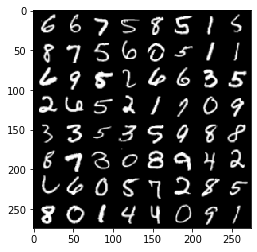

In [16]:
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample = next(iter(trainloader))
show(torchvision.utils.make_grid(sample[0]))
print(sample[0].shape)  ## 64 c'est le batch
                        ## 1 c'est du gris -- sinon ce serait 3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)

maintenant on definit le réseau

In [27]:
class MonReseau(nn.Module):
    def __init__(self):
        super(MonReseau, self).__init__()
        
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 4096)

        self.final = nn.Linear(4096,10)
      
    def forward(self, x):
        x = x.view(-1,1024)  # l'image 1 x 32 x 32 devient un vecteur 1024
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        
        x = self.final(x)
        return x

monreseau = MonReseau()
monreseau = monreseau.cuda()

ensuite on définit les paramètres de l'apprentissage : 
- le solver
- la loss
- le nombre d'itérations ...

In [20]:
optimizer = optim.Adam(monreseau.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
nbepoch = 5

l'apprentissage à proprement parler :
- on itere sur les données
- on les fait rentrer dans le réseau
- on compare la sortie courante à la sortie voulue
- on calcule le gradient 
- on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

**ET ON PASSE SUR CUDA CAR SINON C'EST TROP LONG**

In [28]:
import random
for epoch in range(nbepoch):
  monreseau.train()
  print("epoch", epoch)
  for inputs, targets in trainloader:   ## on itere sur les données 
    inputs, targets = inputs.cuda(),targets.cuda()

    mespredictions = monreseau(inputs)  ## on les fait rentrer dans le réseau
    loss = criterion(mespredictions,targets)  ## on compare la sortie courante à la sortie voulue

    loss.backward() ## le gradient -- la magie par rapport à comment c'était long en court :-)
    optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue

    if random.randint(0,90)==0:
      print("\tloss=",loss) ## on affiche pour valider que ça diverge pas


epoch 0


RuntimeError: ignored